# Notebook pour le prétraitement en tomographie #

Le cahier jupyter a ici pour but d'expliquer les différentes étapes de l'algorithme de prétraitement des hologrammes utilisé au laboratoire.

On utilisera Python 3.7.

## Chargement des modules nécessaires ##
Pour charger les différents modules, on exécutera la cellule de code suivante :

In [1]:
# -*- coding: utf-8 -*-
import matplotlib.pyplot as plt
import scipy.fftpack as sfft
import numpy as np
import HoloProcessing as holo
import CorrectionAberration as CAber
import os
import FileTools as ft
import time

Détaillons un peu l'utilité des modules :
* __pyplot__ sera utilisé pour réaliser les graphiques, importer et exporter les images
* __scipy.fftpack__ contiendra les fonctions permettant de réaliser les transformées de Fourier
* __numpy__ permettra de réaliser des opérations mathématiques avancées sur les tableaux
* __HoloProcessing__ contient une collection de fonctions utiles pour le traitement des hologrammes
* __CorrectionAberration__ contient une collection de fonction utile pour la correction de l'amplitude et de la phase du champ optique
* __os__ permettra de manipuler les fichiers et utiliser des commandes système
* __FileTools__ contient une collection de fonctions pour enregistrer les fichiers et extraire les informations qu'ils contiennent
* __time__ permettra d'estimer le temps d'exécution du programme

## Définition des chemins de recherche des fichiers ##
On définira le chemin pour :
* les données
* le fichiers de configuration, qui contient les paramètres de l'expérience
* un dossier pour sauvegarder les images d'amplitide
* un dossier pour suavegarder les images de phase
* le chemin vers le masque utilisé pour la correction des aberrations.

Les chemins définis ci-dessous sont à remplacer en fonction de la position des différents fichiers sur votre machine.

In [ ]:
DossierData = '../PollenAziz/'
DossierAmplitude = 'C:/Users/p1600109/Documents/Recherche/MatlabTomo/Amplitude/'
DossierPhase = 'C:/Users/p1600109/Documents/Recherche/MatlabTomo/Phase/'
FichierConfig = f"{DossierData}config_manip.txt"
CheminMasque = 'Masque.tif'

## Définition de quelques constantes et lecture du fichier de configuration ##

On choisira ici la méthode de calcul du champ complexe : Born ou Rytov. Et on relira dans le fichier de configuration les informations ayant permis l'acquisition des données.

A noter que le rayon de la sphère d'Ewald est donné par : 
$$R_{\rm Ewald}=\frac{n_{\rm imm}}{\lambda}\frac{N_x\delta_{x}}{G_{\rm tot}},$$ avec $n_{\rm imm}$ l'indice de refraction du milieu d'immersion, $N_x$ la dimension latérale du capteur en pixels, $\delta_{x}$ la dimension physique des pixels du capteur et $G_{\rm tot}$ le grossissement effectif de l'objectif (en tenant compte de la focale de la lentille de tube et de l'éventuelle présence d'un doublet de rééchantillonage). La fréquence maximale accessible sur un hologramme, dépend de l'ouverture numérique de l'objectif et de l'indice de réfraction du milieu d'immersion. Elle est donnée par :
$$f_{{\rm max}_{\rm holo}}=\frac{R_{\rm Ewald}\times{\rm NA}}{n_{\rm imm}}$$

La cellule suivante permet d'initialiser et calculer les valeurs nécessaires pour le reste des calculs.

In [3]:
Rytov = True
CamDim = 1024
NA = ft.readvalue(FichierConfig,'NA')
nimm = ft.readvalue(FichierConfig,'N0')
Lambda = ft.readvalue(FichierConfig,'LAMBDA')
f_tube = ft.readvalue(FichierConfig,'F_TUBE') # Tube lens focal length
f_obj = ft.readvalue(FichierConfig,'F_OBJ') # Microscope objective focal length
pix = ft.readvalue(FichierConfig,'TPCAM') # Physical pixel pitch
RapFoc = ft.readvalue(FichierConfig,'RF') # focal length ratio of the resampling lens dublet
Gtot = f_tube/f_obj/RapFoc
REwald = CamDim*pix/Gtot*nimm/(Lambda) # Ewald sphere radius (pixel)
fmaxHolo = round(REwald*NA/nimm) # Max frequency support (pixel)
dimHolo = int(2*fmaxHolo) # Hologram size
CentreX = int(ft.readvalue(FichierConfig,'CIRCLE_CX')) # Pupil center in Fourier space
CentreY = int(ft.readvalue(FichierConfig,'CIRCLE_CY'))
nb_holoTot = int(ft.readvalue(FichierConfig,'NB_HOLO'))
nb_holo = 1 # Number of holograms in the sequence

## Extraction des coordonnées du centre "shiftées" pour éviter le fftshift ##

Cette opération permet d'accéler fortement le temps de calcul. Il permet de s'affranchir du fftshift sur l'hologramme de pleine dimension. Les coordonnées shiftées sont déduites de _CentreX_ et _CentreY_ :

In [4]:
CentreXShift,CentreYShift = holo.CoordToCoordShift(CentreX, CentreY, CamDim, CamDim)

## Initialisation des polynomes pour la correction d'aberrations ##

Pour réaliser la correction des aberrations et normaliser les hologrammes en amplitude, il est nécessaire de déterminer l'amplitude et la phase du fond (hologramme sans objet). Pour ce faire, on fittera sur l'amplitude et la phase un polynome de degré 4 dans le code qui suit

In [5]:
# Amplitude and phase correction initialisation
Masque = CAber.InitMasque(CheminMasque,dimHolo)
nbPtOK = CAber.PixInMask(Masque)
degrePoly = 4
nbCoef = CAber.SizePoly2D(degrePoly)

# Undersampled polynome        
Poly_US = np.zeros((nbCoef,nbPtOK),dtype=np.float64)        
Poly_US = CAber.CalcPolyUS_xy(degrePoly,Masque,Poly_US)

# Polynome to be fitted
Poly = np.zeros((nbCoef,dimHolo*dimHolo),dtype=np.float64)          
Poly = CAber.CalcPoly_xy(degrePoly,Masque,Poly)

Mask Opening


## Application au traitement d'un hologramme ##

On réalisera le prétraitement sur un des hologrammes enregistrés. On ouvrira l'image __i001.pgm__

<function matplotlib.pyplot.show(*args, **kw)>

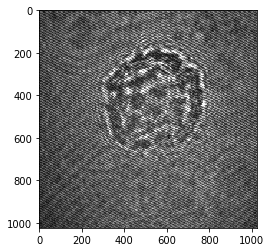

In [6]:
cpt = 1
filename = f"{DossierData}i{'%03d' % cpt}.pgm"
Image = plt.imread(filename)
plt.imshow(Image,cmap="gray")
plt.show

Réalisons maintenant la transformée de Fourier de l'hologramme

<function matplotlib.pyplot.show(*args, **kw)>

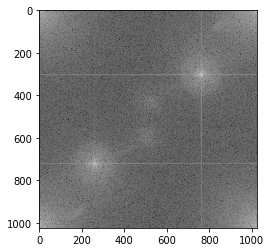

In [7]:
FImage = sfft.fft2(Image)
plt.imshow(np.log(np.abs(FImage)),cmap="gray")
plt.show

et le filtrage de l'ordre +1

<function matplotlib.pyplot.show(*args, **kw)>

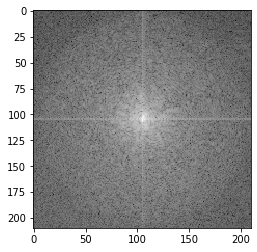

In [8]:
SpectreFilt=FImage[int(CentreYShift-fmaxHolo):int(CentreYShift+fmaxHolo),int(CentreXShift-fmaxHolo):int(CentreXShift+fmaxHolo)]
plt.imshow(np.log(np.abs(SpectreFilt)),cmap="gray")
plt.show

On peut extraire les coordonnées du spot spéculaire, qui servira lors de la reconstruction 3D de l'objet : 

In [9]:
ind = np.unravel_index(np.argmax(np.abs(SpectreFilt), axis=None), SpectreFilt.shape)
kiy = ind[0]
kix = ind[1]
print(f"kiy={kiy}, kix={kix}\n")

kiy=105, kix=105



Déterminons l'amplitude du champ complexe avant correction

<function matplotlib.pyplot.show(*args, **kw)>

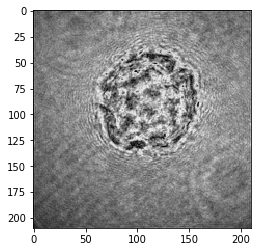

In [10]:
UBorn = sfft.ifft2(sfft.ifftshift(SpectreFilt))
Amp_UBorn = np.abs(UBorn)
plt.imshow(Amp_UBorn,cmap="gray")
plt.show

Et la phase du champ complexe

<function matplotlib.pyplot.show(*args, **kw)>

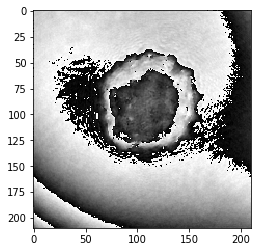

In [11]:
Phase_UBornWrap = np.angle(UBorn)
plt.imshow(Phase_UBornWrap,cmap="gray")
plt.show

La phase obtenue est pliée : elle présente des discontinuités pour les valeurs $\pm \pi$. Il est nécessaire de dérouler cette phase.

<function matplotlib.pyplot.show(*args, **kw)>

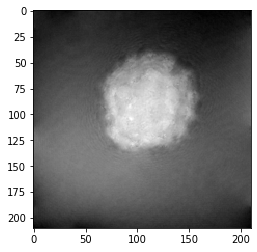

In [12]:
Phase_UBorn = holo.unwrapping(Phase_UBornWrap, pix)
plt.imshow(Phase_UBorn,cmap="gray")
plt.show

Pour normaliser l'amplitude des hologrammes et corriger les aberrations de phase, on applique la routine d'ajustement d'un polynome sur l'amplitude :

<function matplotlib.pyplot.show(*args, **kw)>

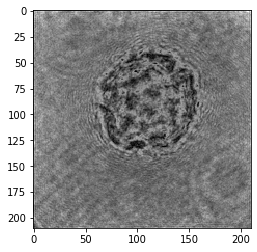

In [13]:
Amp_UBornCorr = CAber.ampliCorr(Amp_UBorn,Masque,Poly_US,Poly)
plt.imshow(Amp_UBornCorr,cmap="gray")
plt.show

et sur la phase : 

<function matplotlib.pyplot.show(*args, **kw)>

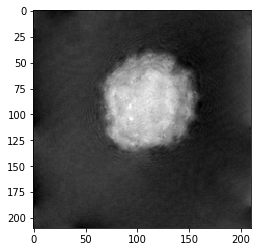

In [14]:
Phase_UBornCorr = CAber.aberCorr(Phase_UBorn,Masque,Poly_US,Poly) 
plt.imshow(Phase_UBornCorr,cmap="gray")
plt.show

Enfin, on peut obtenir le champ optique dans l'approximation de Rytov ou dans l'approximation de Born :

<function matplotlib.pyplot.show(*args, **kw)>

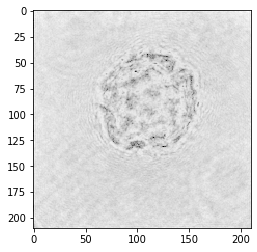

In [15]:
if Rytov is True:
    # Rytov
    Re_UBorn = np.log(np.abs(Amp_UBornCorr))
    Im_UBorn = Phase_UBornCorr
else:
    # Born
    Re_UBorn = (Amp_UBornCorr-1)*np.cos(Phase_UBornCorr)
    Im_UBorn = (Amp_UBornCorr-1)*np.sin(Phase_UBornCorr)
plt.imshow(Re_UBorn,cmap="gray")
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

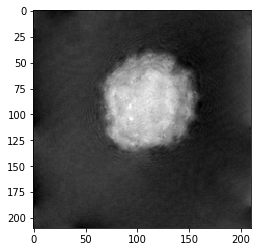

In [17]:
plt.imshow(Im_UBorn,cmap="gray")
plt.show

Le champ calculé (partie réelle et partie imaginaire peut alors être utilisé pour la reconstruction. Il est alors nécessaire de lancer le prétraitement pour l'ensemble des images acquises.